In [1]:
import os 
import pandas as pd 
import numpy as np 
from glob import glob
# from scipy import signal, fft
# from scipy.io import wavfile
import librosa
import matplotlib.pyplot as plt

import scipy.signal
from scipy.signal.windows import hann

# import torch
# import torchaudio
# from torch.utils.data import Dataset

import tensorflow as tf 


import matplotlib.pyplot as plt
import librosa.display
from PIL import Image
import numpy as np

In [2]:
all_files = pd.read_csv('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/files.csv')
all_files.head()

,filename,train/test,sounds_amount
0,423_c.wav,train,24
1,113_c.wav,train,6
2,377_c.wav,train,5
3,25_g.wav,train,4
4,112_c.wav,train,9


In [3]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'train')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'train')])

(1023, 262)

In [4]:
len(all_files[(all_files['sounds_amount'] > 0) & (all_files['train/test']  == 'test')]), len(all_files[(all_files['sounds_amount'] == 0) & (all_files['train/test']  == 'test')])

(260, 61)

In [5]:
wav_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.wav')
csv_files = glob('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/*_c.csv')
len(wav_files), len(csv_files)

(427, 427)

In [6]:
wav_train, wav_test = [], [] 
csv_train, csv_test = [], [] 

# for i in range(len(wav_files)):
for key, val in all_files.iterrows():
    if 'train' in val['train/test']:
        wav_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_train.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))
    else:
        wav_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename']))
        csv_test.append(os.path.join('/Users/sehwanyoo/Dropbox/Experiment/datasets/data/', val['filename'].replace('wav', 'csv')))

In [7]:
len(wav_train), len(wav_test), len(csv_train), len(csv_test)

(1285, 321, 1285, 321)

In [8]:
total_category = {} 
for csv in csv_train:
    df = pd.read_csv(csv)
    
    try:
        unique_elements, counts = np.unique(df['category'].astype(str), return_counts=True)
        # element_counts_dict = dict(zip(unique_elements, counts))
        
        if len(unique_elements) < 1:
            continue
        
        for e, c in zip(unique_elements, counts):
            if e in total_category:
                total_category[e] += c
            else:
                total_category[e] = c
    except Exception as e:
        print(e)
            
    # break

total_category
        

{'s': 2819, 'm': 16, 'nan': 2152, 'b': 90, 'bc': 94, 'o': 1, 'a': 32, 'd': 2}

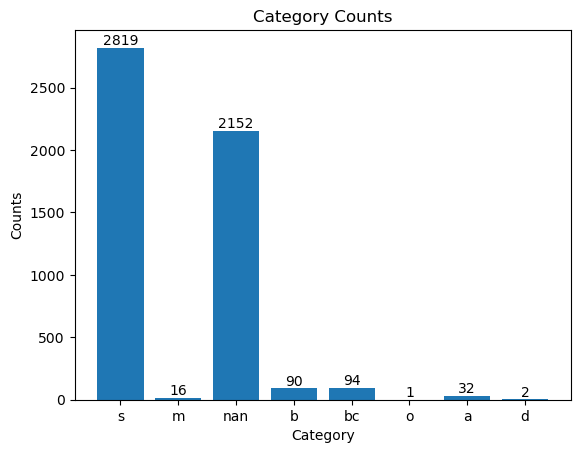

In [9]:
categories = list(total_category.keys())
counts = list(total_category.values())

# 막대 그래프 생성
plt.bar(categories, counts)

for index, value in enumerate(counts):
    plt.text(index, value, str(value), ha='center', va='bottom')


plt.xlabel('Category')  # X축 레이블
plt.ylabel('Counts')    # Y축 레이블
plt.title('Category Counts')  # 그래프 제목
plt.show()

In [10]:
df = pd.read_csv(csv_train[0])
df.head()

,start,end,fmin,fmax,category
0,0.014694,0.046621,165.242172,1903.133911,s
1,0.183039,0.213515,216.524216,1954.415894,s
2,0.339773,0.374603,216.524216,598.290649,s
3,0.583583,0.606803,119.658119,592.592590,s
4,0.879637,0.917370,153.846161,723.646729,s


In [11]:
def spectrogram(samples, sample_rate, stride_sec = 2.0, 
                          window_sec = 4.0, max_freq = 1500, eps = 1e-4):

    stride_size = int(sample_rate * stride_sec)
    window_size = int(sample_rate * window_sec)

    # Extract strided windows
    truncate_size = (len(samples) - window_size) % stride_size
    samples = samples[:len(samples) - truncate_size]
    nshape = (window_size, (len(samples) - window_size) // stride_size + 1)
    nstrides = (samples.strides[0], samples.strides[0] * stride_size)
    windows = np.lib.stride_tricks.as_strided(samples, 
                                          shape = nshape, strides = nstrides)
    # print(windows.shape)
    # assert np.all(windows[:, 1] == samples[stride_size:(stride_size + window_size)])

    # Window weighting, squared Fast Fourier Transform (fft), scaling
    weighting = np.hanning(window_size)[:, None]
    
    fft = np.fft.rfft(windows * weighting, axis=0)
    fft = np.absolute(fft)
    fft = fft**2
    
    scale = np.sum(weighting**2) * sample_rate
    fft[1:-1, :] *= (2.0 / scale)
    fft[(0, -1), :] /= scale
    
    # Prepare fft frequency list
    freqs = float(sample_rate) / window_size * np.arange(fft.shape[0])
    
    # Compute spectrogram feature
    ind = np.where(freqs <= max_freq)[0][-1]
    specgram = np.log(fft[:ind, :] + eps).astype(np.float32)
    return specgram

In [12]:

def norm_img(input_imgs, n_min, n_max):
    imgs = []
    for i in range(input_imgs.shape[0]):
        img = input_imgs[i]
        x = (img - n_min) / (n_max - n_min)
        img = x.clip(0, 1)
        imgs.append(img)
    
    return np.array(imgs)

In [17]:
y, sr = librosa.load(wav_train[0], sr=44100)
y, sr

(array([-0.00405884, -0.00405884, -0.00402832, ..., -0.01525879,
        -0.01525879, -0.01522827], dtype=float32),
 44100)

In [16]:
spec_y = spectrogram(y, sr, stride_sec=2.0, window_sec=4.0, max_freq=1500, eps=0.001)
spec_y

array([], shape=(6000, 0), dtype=float32)